# Data Scientist Challenge LATAM Airlines

The problem consists in predicting the probability of delay of the flights that land or take off from the airport of Santiago de Chile
(SCL). For that you will have a dataset using public and real data where each row corresponds to a flight that landed or took off
from SCL during 2017. The following information is available for each flight:

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch

data  = pd.read_csv('dataset_SCL.csv')

/home/nicofredes/miniconda3/envs/main/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_52439/1001833564.py:8: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data  = pd.read_csv('dataset_SCL.csv')


# 1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

In [2]:
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [3]:
data['Fecha-I'] = pd.to_datetime(data['Fecha-I'])

In [4]:
# daa distribuida a lo largo de todo el 2017
data['Fecha-I']

0       2017-01-01 23:30:00
1       2017-01-02 23:30:00
2       2017-01-03 23:30:00
3       2017-01-04 23:30:00
4       2017-01-05 23:30:00
                ...        
68201   2017-12-22 14:55:00
68202   2017-12-25 14:55:00
68203   2017-12-27 14:55:00
68204   2017-12-29 14:55:00
68205   2017-12-31 14:55:00
Name: Fecha-I, Length: 68206, dtype: datetime64[ns]

In [5]:
# hay diversidad en las siguentes variables
print('VLO-I ', data['Vlo-I'].nunique(), '\n', 'DES-I' , data['Des-I'].nunique(), '\n', 'Emp-I', data['Emp-I'].nunique())

VLO-I  750 
 DES-I 64 
 Emp-I 30


In [6]:
#todos los vuelos salen de santiago
data['Ori-O'].unique()

array(['SCEL'], dtype=object)

In [7]:
#no solo hay cambios en la hora programada, si no que las otras variables operacionales tambien cambian
(data['Emp-I'] != data['Emp-O']).sum()

18669

In [8]:
#hay datos operacionales del 2018
data['AÑO'].unique()

array([2017, 2018])

In [9]:
# hay datos operacionales del 2018 son despreciables y se deben a pequeños retrasos de año nuevo
data[data['AÑO']==2018]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
66918,2017-12-31 23:55:00,602,SCEL,KLAX,LAN,2018-01-01 00:02:00,602.0,SCEL,KLAX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Los Angeles
66947,2017-12-31 23:40:00,622,SCEL,MMMX,LAN,2018-01-01 00:12:00,622.0,SCEL,MMMX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Ciudad de Mexico


In [10]:
data['Month-I'] = data['Fecha-I'].dt.strftime('%m')
data['Hour-I'] = data['Fecha-I'].dt.strftime('%H')

In [11]:
data.head(2)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,Month-I,Hour-I
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,01,23
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,01,23


<AxesSubplot: xlabel='Hour-I', ylabel='Count'>

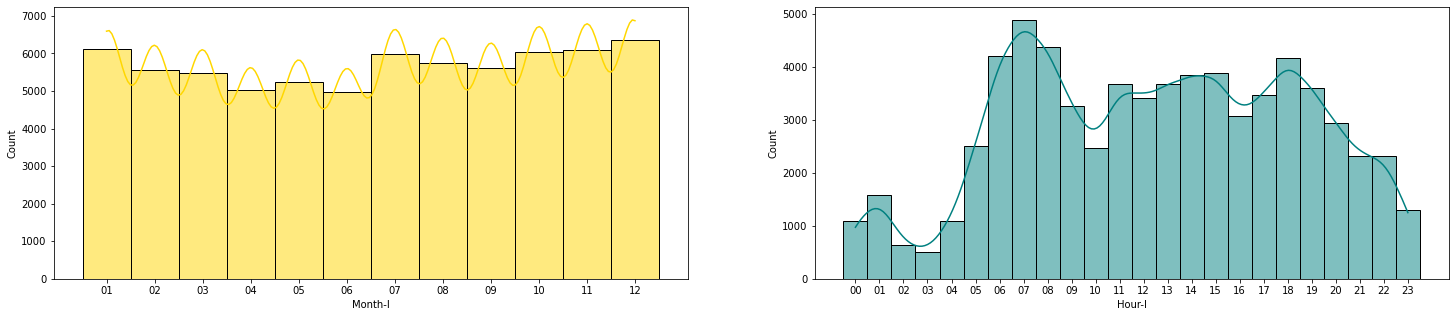

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))

sns.histplot(data=data, x='Month-I', kde=True, color="gold", ax=axs[0])
sns.histplot(data=data.sort_values(by=['Hour-I']), x='Hour-I', kde=True, color="teal", ax=axs[1])

<AxesSubplot: xlabel='Count', ylabel='Des-I'>

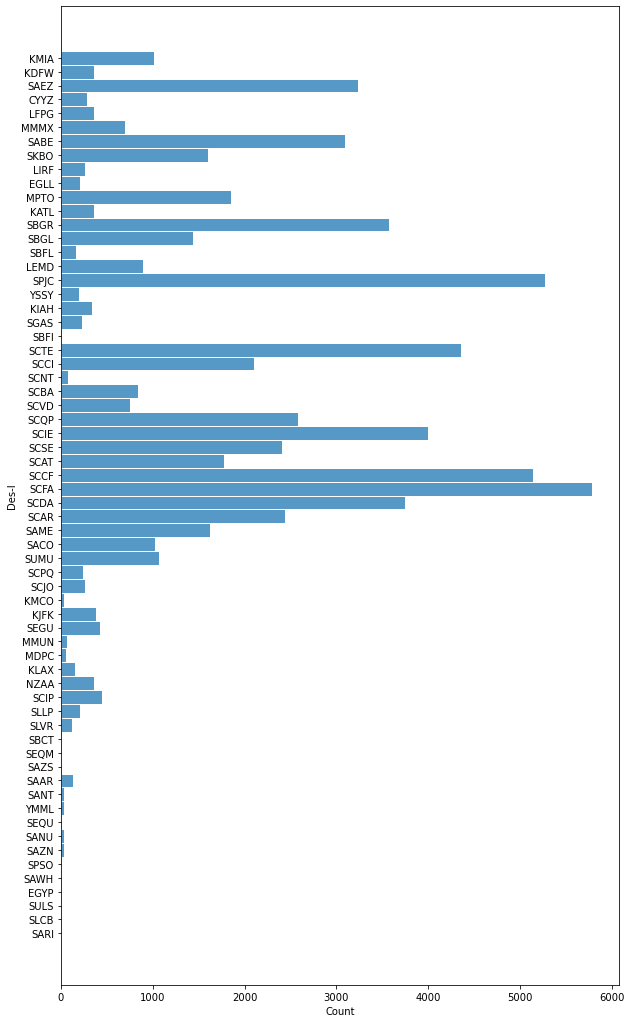

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(10, 18))
sns.set_style("whitegrid")
sns.histplot(y=data['Des-I'])

<AxesSubplot: xlabel='Count', ylabel='Emp-I'>

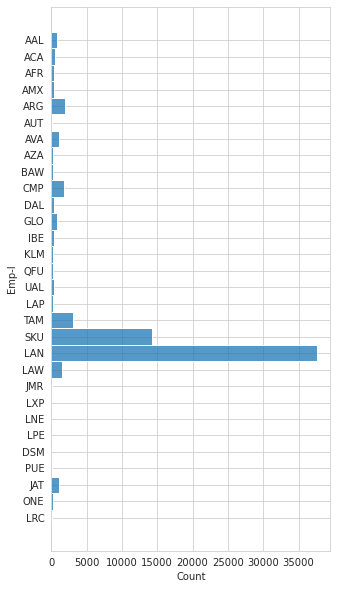

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(5, 10))
sns.set_style("whitegrid")
sns.histplot(y=data['Emp-I'])

# Answer 1:
The data is uniformly distributed throughout the months of the year, with a decrease in flight departures in the early hours of the morning. The scheduled destination shows great diversity, with a widely scattered distribution. Additionally, the airline distribution stands out, with LAN being the primary carrier and SKU being a secondary carrier, which can be attributed to the fact that the client, LATAM, has greater access to their own data.

In other columns, it can be observed that all flights depart from Santiago, Chile. Furthermore, variations between the scheduled and actual flight times are not only time-related, but airline-related as well. It is worth noting that two delays occurred at the end of the last day of 2017, which introduced two data points from 2018 into the actual flight times.

In conclusion, all data is from flights departing from Santiago, with none arriving there, thus the objective will be to predict the probability of delays in departures from Santiago. The time of day and year of the flight departure are dispensable as they do not vary. Additionally, airline and destination variables will be of particular importance due to their non-uniform distributions.

# 2. Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:

○ high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.

○ min_diff : difference in minutes between Date-O and Date-I .

○ delay_15 : 1 if min_diff > 15, 0 if not.

○ period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I .

In [15]:
# HIGH SEASON
fechas = data['Fecha-I'].dt.strftime('%Y-%m-%d')
high_season_1 = (fechas <= '2017-03-03') | (fechas >= '2017-12-15')
high_season_2 = (fechas <= '2017-07-31') & (fechas >= '2017-15-31')
high_season_3 = (fechas <= '2017-09-30') & (fechas >= '2017-09-11')
high_season = high_season_1 | high_season_2 | high_season_3
data['high_season'] = high_season.astype(int)

In [16]:
# MIN_DIFF
data['Fecha-O'] = pd.to_datetime(data['Fecha-O'])
data['min_diff'] = (data['Fecha-O'] - data['Fecha-I']).dt.total_seconds()/60
data['min_diff'] = data['min_diff'].astype(int)

In [17]:
#DELAY_15
data['delay_15'] = (data['min_diff'] > 15).astype(int)

In [18]:
#PERIOD_DAY
data['period_day'] =  pd.cut(data['Fecha-I'].dt.strftime('%H').astype(int) , bins=[-1, 4, 11, 18, 24], labels=['night', 'morning', 'afternoon', 'night_1'])
data['period_day'] = data['period_day'].apply(lambda x: 'night' if x == 'night_1' else x)

In [19]:
data[['high_season', 'min_diff', 'delay_15', 'period_day']].to_csv('synthetic_features.csv', index=False)

# 3. What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What variables would you expect to have the most influence in predicting delays?

In [20]:
data['DIANOM-I'] = data['Fecha-I'].dt.day_name()

se analizara el min_diff en funcion de 'Des-I', 'Emp-I', 'Month-I', 'DIANOM-I', 'high_season', 'TIPOVUELO'

Se procede a generar un grafico para distribucion de min_diff para cada uno de los valors de la variable Des-I
Posteriormente se grafica la distribución de promedios de valores de mindiff para cada valor de destino

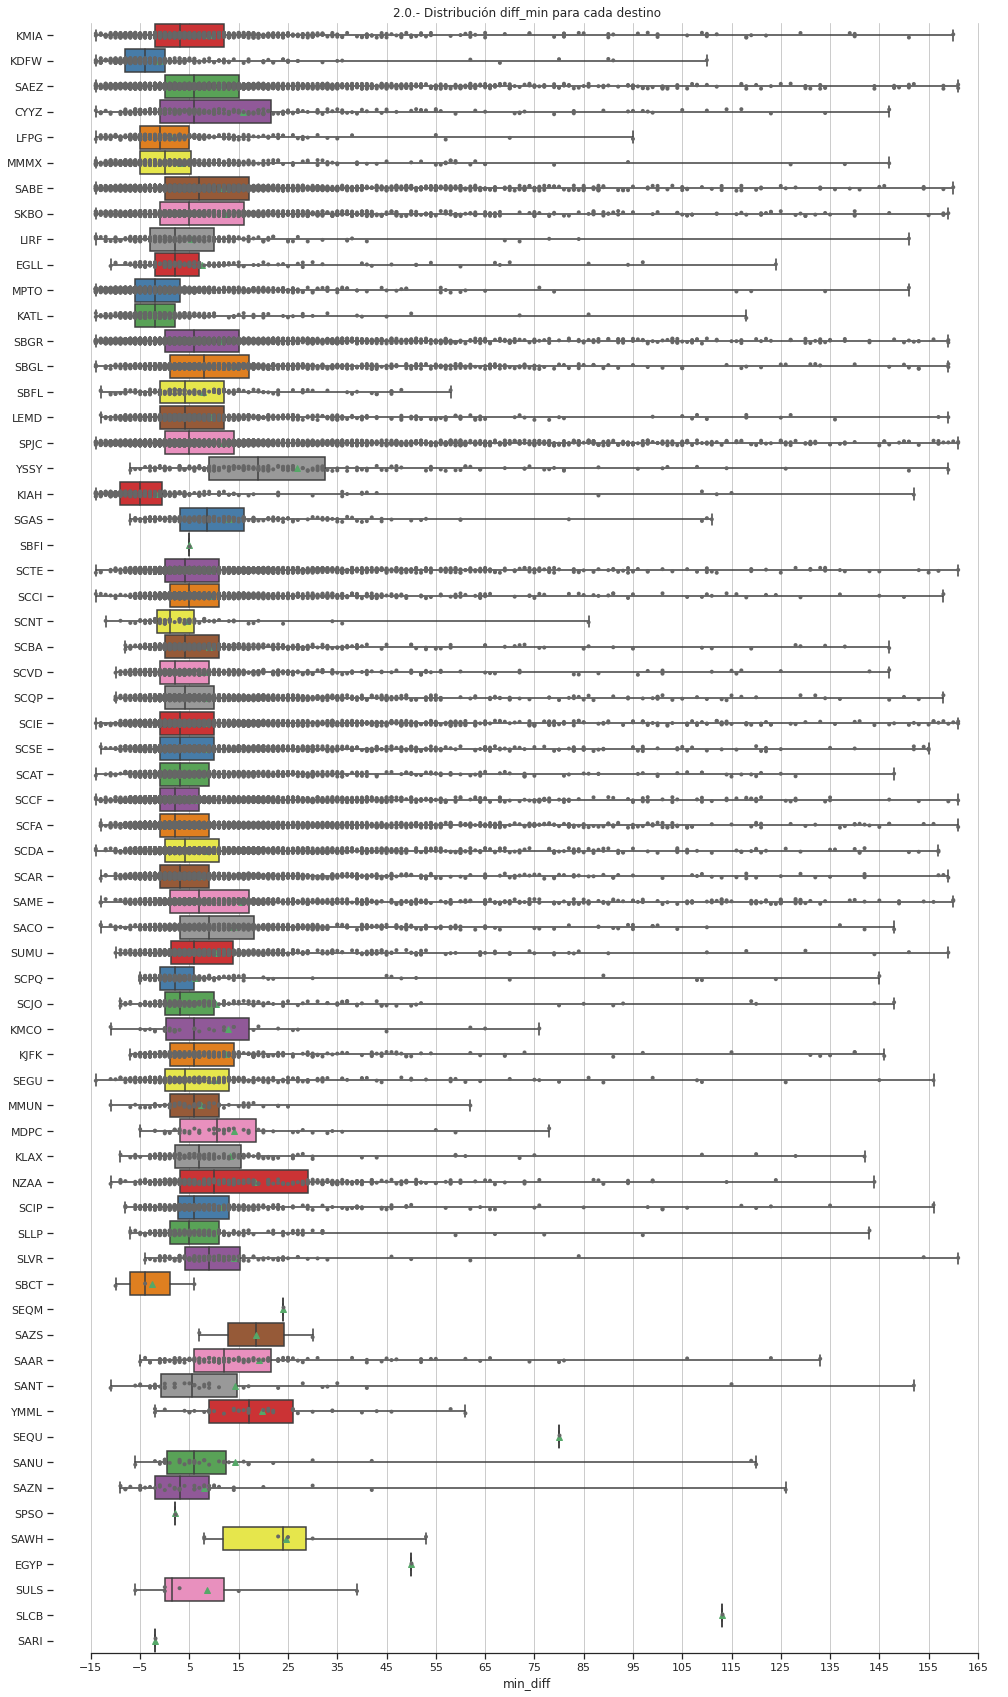

In [21]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(17, 30))

sns.boxplot(x="min_diff", y="Des-I", data=data,
            whis=[0, 100], width=.9, palette="Set1", showmeans=True).set(title='2.0.- Distribución diff_min para cada destino', xticks=range(-25, 175, 10))

sns.stripplot(x="min_diff", y="Des-I", data=data,
              size=4, color=".4", linewidth=0)

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

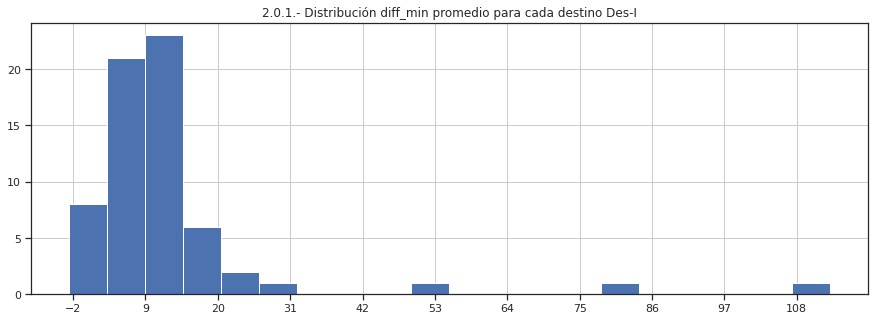

In [22]:
column = 'Des-I'
promedios = data.groupby(column)['min_diff'].mean()
plot = promedios.hist(bins=20, figsize=(15, 5))
min = int(promedios.min())
max = int(promedios.max())
delta = int((max - min)/10)
show = plot.set(xticks=range(min, max, delta), title='2.0.1.- Distribución diff_min promedio para cada destino ' + column) 

Se procede a generar un grafico para distribucion de min_diff para cada uno de los valors de la variable Emp-I
Posteriormente se grafica la distribución de promedios de valores de mindiff para cada valor de Aerolinea

/home/nicofredes/miniconda3/envs/main/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


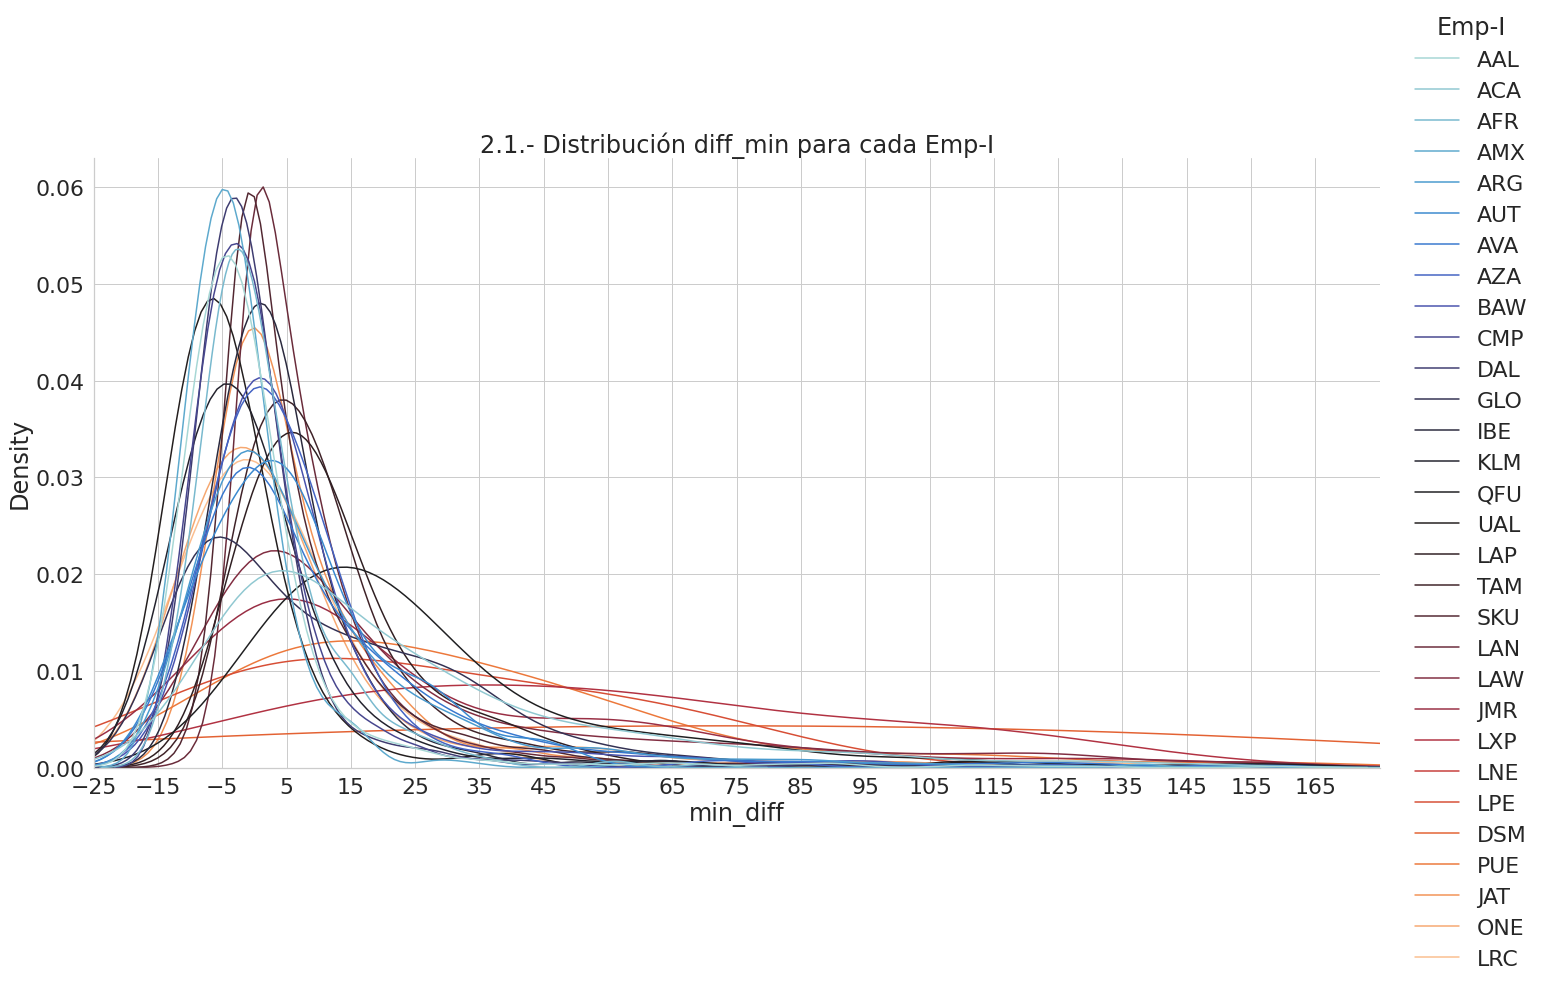

In [23]:
column = 'Emp-I'
feature = data[column]
colors = sns.color_palette("icefire", n_colors=feature.nunique())
palette = {mode: color for mode, color in zip(feature.unique(), colors)}
sns.set(font_scale=2)
sns.set_style("whitegrid")
plot = sns.displot(data=data, x="min_diff", hue=column, kind="kde", palette=palette, height=10, aspect=2, legend=True, common_norm=False)
plot.set(
    title='2.1.- Distribución diff_min para cada ' + column,
    xlim=(-25, 175),
    xticks=range(-25, 175, 10)
)

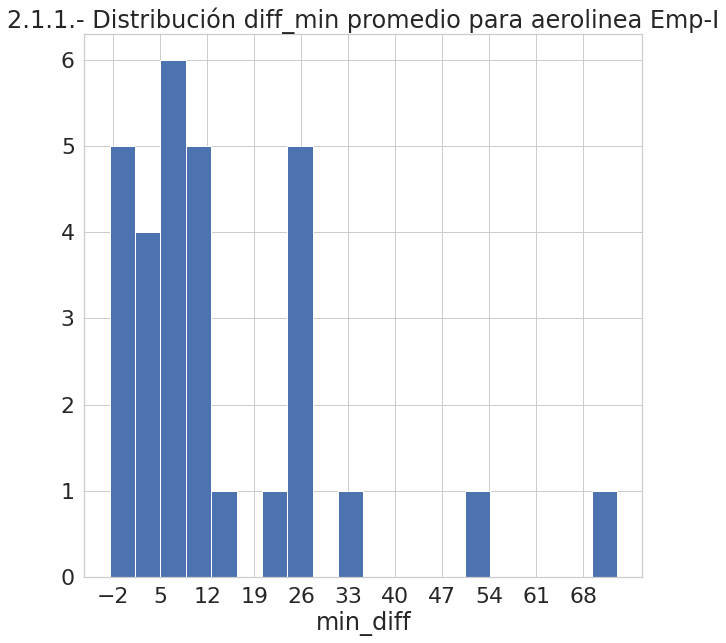

In [24]:
column = 'Emp-I'
promedios = data.groupby(column)['min_diff'].mean()
plot = promedios.hist(bins=20, figsize=(10, 10))
min = int(promedios.min())
max = int(promedios.max())
delta = int((max - min)/10)
show = plot.set(xticks=range(min, max, delta), title='2.1.1.- Distribución diff_min promedio para aerolinea ' + column, xlabel='min_diff') 

Se procede a generar un grafico para distribucion de min_diff para cada uno de los valors de la variable month-I
Posteriormente se grafica la distribución de promedios de valores de mindiff para cada mes

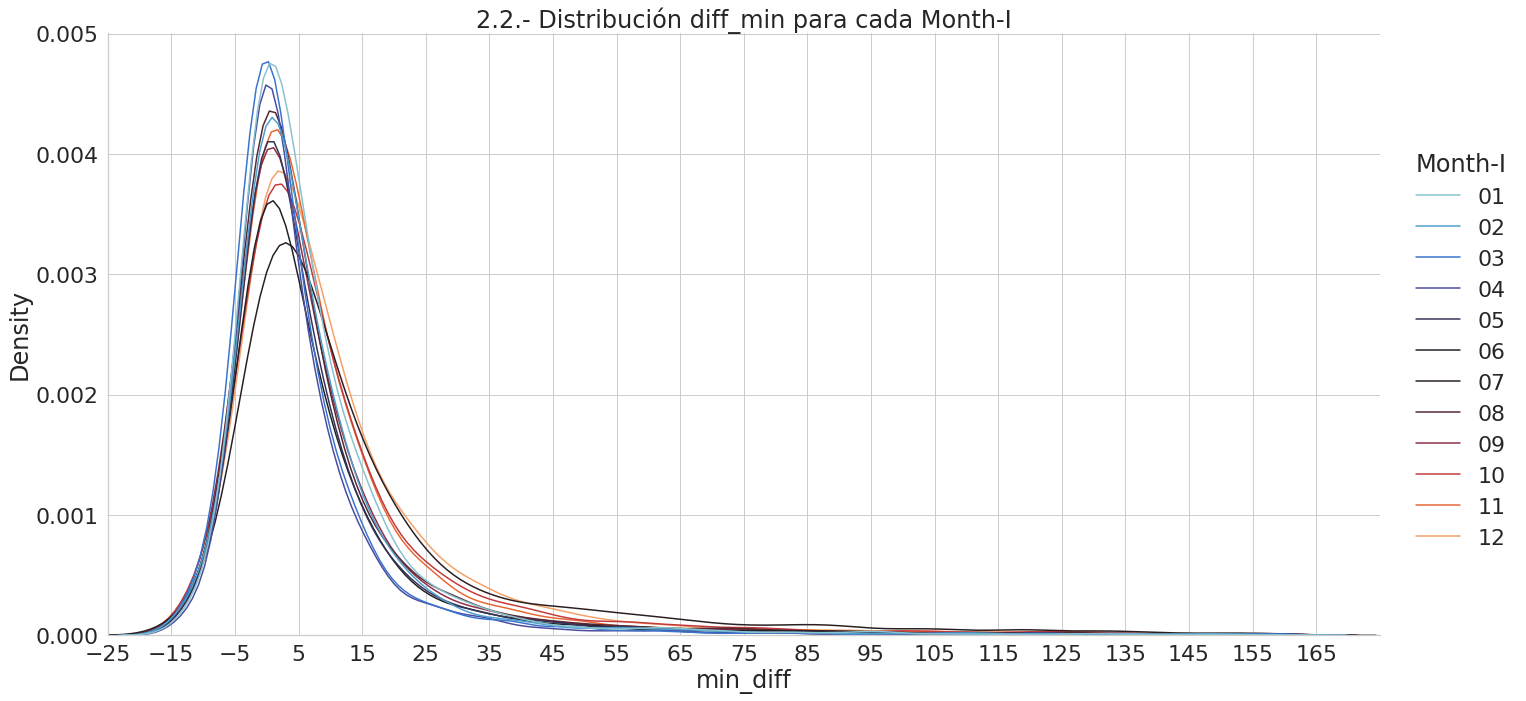

In [25]:
column = 'Month-I'
feature = data[column]
colors = sns.color_palette("icefire", n_colors=feature.nunique())
palette = {mode: color for mode, color in zip(feature.unique(), colors)}
sns.set(font_scale=2)
sns.set_style("whitegrid")
plot = sns.displot(data=data, x="min_diff", hue=column, kind="kde", palette=palette, height=10, aspect=2, legend=True)
plot.set(
    title='2.2.- Distribución diff_min para cada ' + column,
    xlim=(-25, 175),
    xticks=range(-25, 175, 10)
)

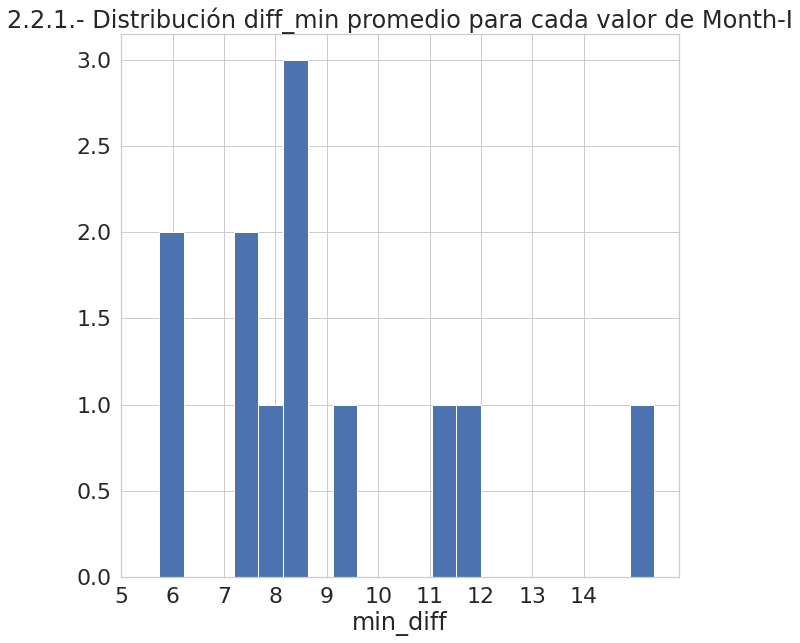

In [26]:
column = 'Month-I'
promedios = data.groupby(column)['min_diff'].mean()
plot = promedios.hist(bins=20, figsize=(10, 10))
min = int(promedios.min())
max = int(promedios.max())
delta = int((max - min)/10)
show = plot.set(xticks=range(min, max, delta), title='2.2.1.- Distribución diff_min promedio para cada valor de ' + column, xlabel='min_diff') 

Se procede a generar un grafico para distribucion de min_diff para cada uno de los valors de la variable DIANOM-I
Posteriormente se grafica la distribución de promedios de valores de mindiff para cada DÍA DE LA SEMANA

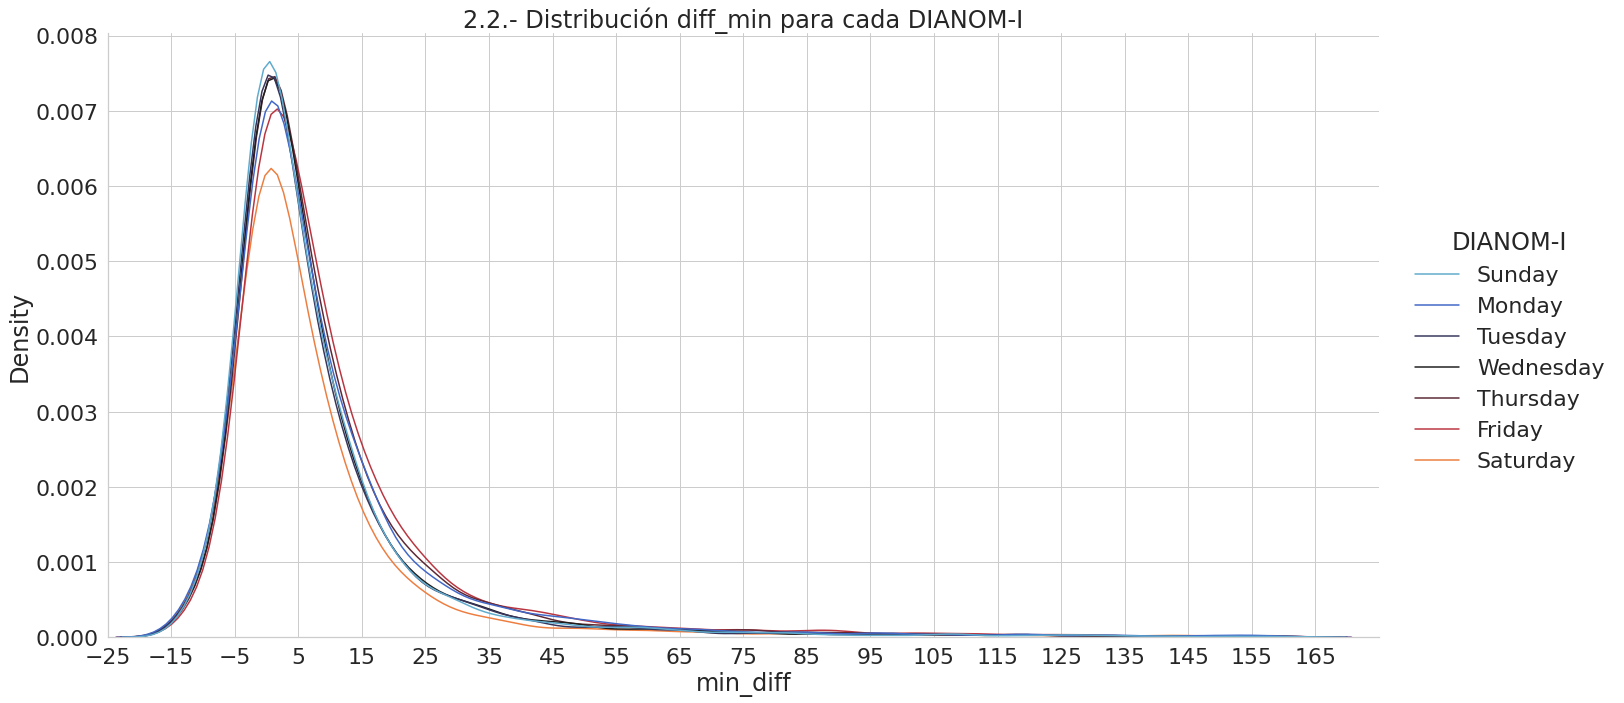

In [27]:
column = 'DIANOM-I'
feature = data[column]
colors = sns.color_palette("icefire", n_colors=feature.nunique())
palette = {mode: color for mode, color in zip(feature.unique(), colors)}
sns.set(font_scale=2)
sns.set_style("whitegrid")
plot = sns.displot(data=data, x="min_diff", hue=column, kind="kde", palette=palette, height=10, aspect=2, legend=True)
plot.set(
    title='2.2.- Distribución diff_min para cada ' + column,
    xlim=(-25, 175),
    xticks=range(-25, 175, 10)
)

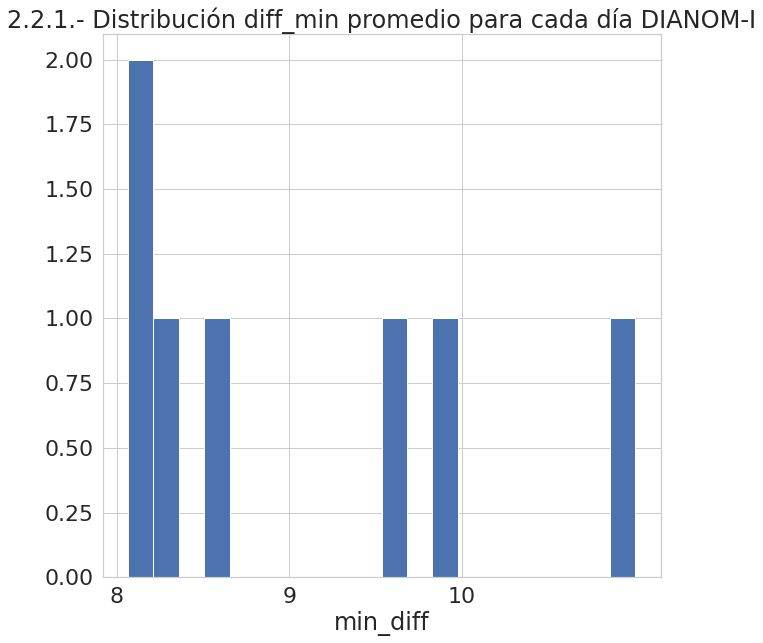

In [28]:
promedios = data.groupby(column)['min_diff'].mean()
plot = promedios.hist(bins=20, figsize=(10, 10))
min = int(promedios.min())
max = int(promedios.max())
delta = int((max - min)/10)
show = plot.set(xticks=range(min, max, delta+1), title='2.2.1.- Distribución diff_min promedio para cada día ' + column, xlabel='min_diff') 

Se grafican las istribuciones de retrasos para cada par de valores de las variables 'high_season' y 'TIPOVUELO'.

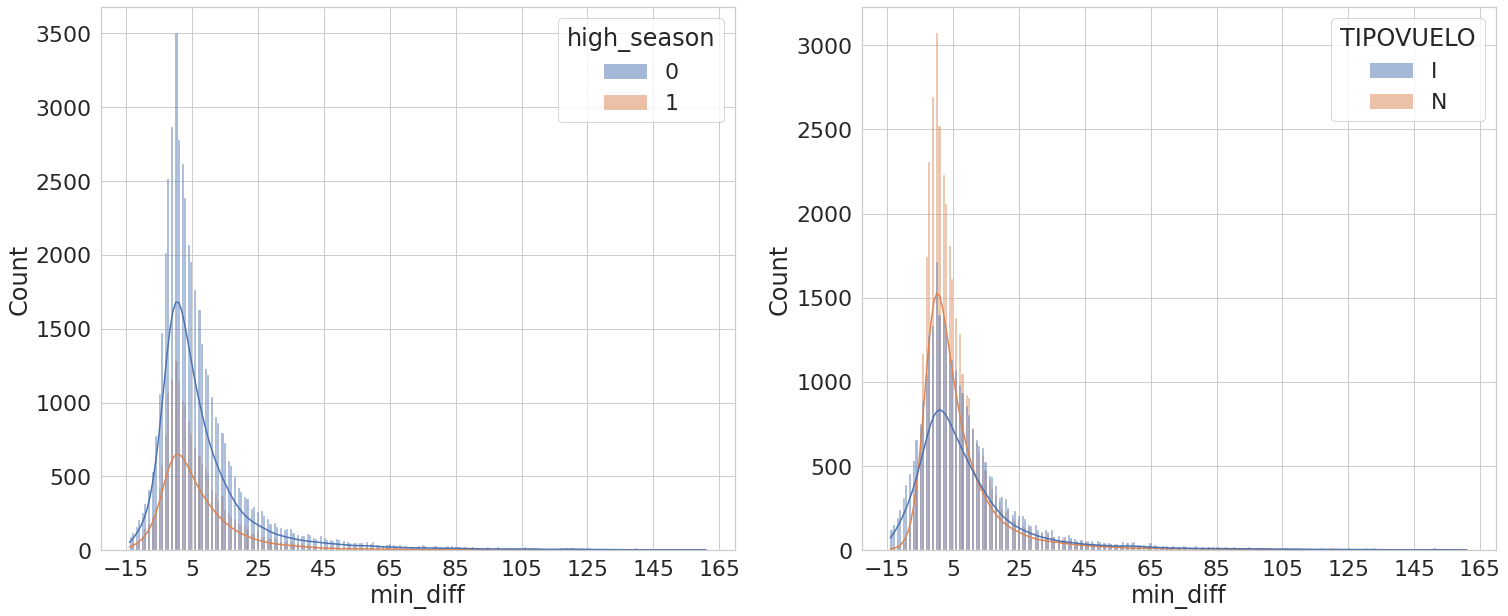

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))

plt1 = sns.histplot(data=data, x="min_diff", hue='high_season', kde=True, color="skyblue", ax=axs[0]).set(xticks=range(-15, 175, 20))
plt2 = sns.histplot(data=data, x="min_diff", hue='TIPOVUELO', kde=True, color="olive", ax=axs[1]).set(xticks=range(-15, 175, 20))

# ANSWER 3.- In most of the reviewed variables, flight delay does not vary much, concentrating mainly within the first 15 minutes from the scheduled time. The variable that represents the highest variability and impact on delay is the airline or company. Therefore, it is deduced that this variable will be of particular importance for the model's capacity.

# 4. Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay. Feel free to generate additional variables and/or supplement with external variables.

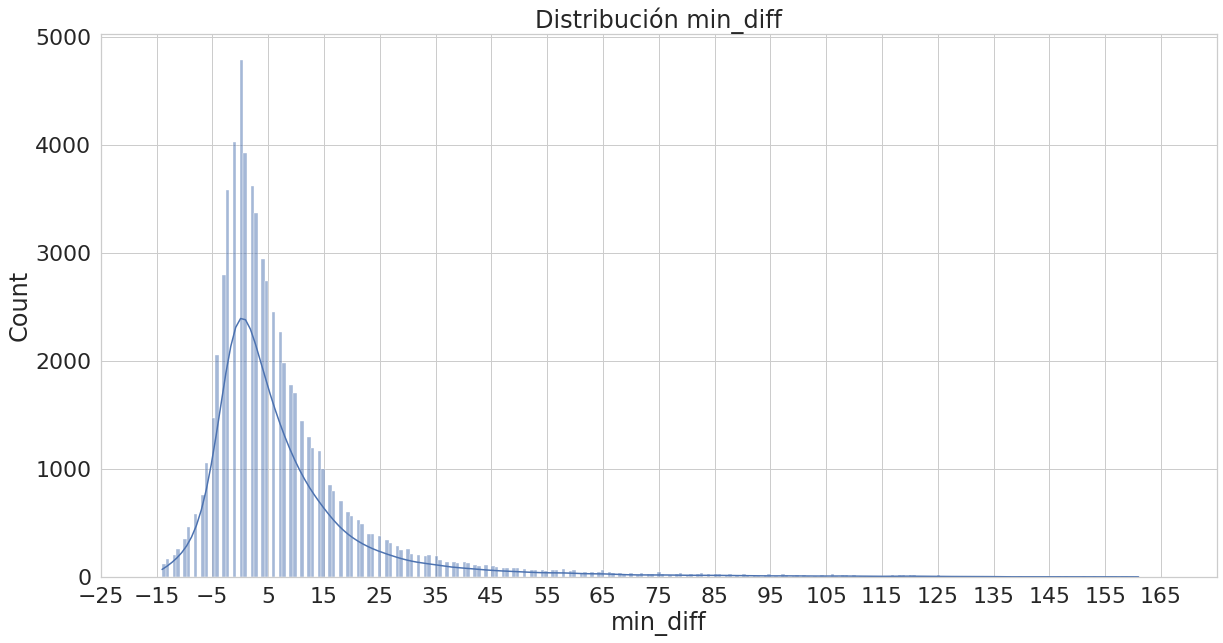

In [30]:
f, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=2)
sns.set_style("whitegrid")
plot = sns.histplot(data=data, x="min_diff", kde=True)
show = plot.set(
    title='Distribución min_diff',
    xlim=(-25, 175),
    xticks=range(-25, 175, 10)
)

In [31]:
data["min_diff"].describe()

count    68206.000000
mean         9.110855
std         19.313387
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: min_diff, dtype: float64

In [32]:
data["min_diff"].quantile([.2, .4, .6, .8, .9])

0.2    -2.0
0.4     2.0
0.6     6.0
0.8    14.0
0.9    26.0
Name: min_diff, dtype: float64

Since the delay distribution analyzed in question 2 is around 0 to 15 minutes in multiple variables, and the min_se variable's overall distribution behaves in the same way, it seems reasonable to assume the threshold at this time. Additionally, a delay of 15 minutes covers the 81st percentile, which is a considerably representative amount of the "normal" behavior of plane departures. Therefore, it is assumed that a flight that departs with less than a 15-minute delay is considered to have arrived "on time," and for an equal or greater delay of 15 minutes or more, it will be considered a delayed flight.

In this way, the problem is redefined as predicting the value of the 'delay_15' variable, where a value of 1 means that the flight will depart with a delay, and a value of 0 means the opposite. Intermediate values can and will be interpreted as probabilities.

Se procede a separar la data con delay_15 en 0 y 1, para realizar en cada grupo la divicion en train, val y test, y luego juntar cada par de grupos. Esto se realiza para tener una distribución parecida de 0 y 1 en cada uno de los dataset. En cada grupo además se seleccionará app un 10% de cada mes del año al azar para validation y otro 10% para testing. Se realiza de esta forma para evadir la introducción de sezgos de temporadas y meses en el modelo y distribuciones de probabilidades.

In [33]:
data

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,OPERA,SIGLAORI,SIGLADES,Month-I,Hour-I,high_season,min_diff,delay_15,period_day,DIANOM-I
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,01,23,1,3,0,night,Sunday
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,01,23,1,9,0,night,Monday
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,01,23,1,9,0,night,Tuesday
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,01,23,1,3,0,night,Wednesday
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,American Airlines,Santiago,Miami,01,23,1,-2,0,night,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,12,14,1,46,1,afternoon,Friday
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,12,14,1,16,1,afternoon,Monday
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,12,14,1,40,1,afternoon,Wednesday
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,...,JetSmart SPA,Santiago,Lima,12,14,1,13,0,afternoon,Friday


In [34]:
#SE AGREGA LA VARIABLE NUMERO DE DIA DEL MES
data['DIA-I'] = data['Fecha-I'].dt.day

In [35]:
data_model = data[['period_day', 'DIANOM-I', 'DIA-I', 'Month-I', 'high_season', 'TIPOVUELO', 'Emp-I', 'Des-I', 'delay_15']].copy()

In [36]:
data_model

,period_day,DIANOM-I,DIA-I,Month-I,high_season,TIPOVUELO,Emp-I,Des-I,delay_15
0,night,Sunday,1,01,1,I,AAL,KMIA,0
1,night,Monday,2,01,1,I,AAL,KMIA,0
2,night,Tuesday,3,01,1,I,AAL,KMIA,0
3,night,Wednesday,4,01,1,I,AAL,KMIA,0
4,night,Thursday,5,01,1,I,AAL,KMIA,0
...,...,...,...,...,...,...,...,...,...
68201,afternoon,Friday,22,12,1,I,JAT,SPJC,1
68202,afternoon,Monday,25,12,1,I,JAT,SPJC,1
68203,afternoon,Wednesday,27,12,1,I,JAT,SPJC,1
68204,afternoon,Friday,29,12,1,I,JAT,SPJC,0


In [37]:
data_model.reset_index(inplace=True)

In [38]:
data_model = data_model.astype({'period_day': str, 'DIANOM-I': str, 'DIA-I': 'int32', 'Month-I': 'int32', 'high_season': 'int32', 'TIPOVUELO': str, 'Emp-I': str, 'Des-I': str, 'delay_15': 'int32'})

In [39]:
data_model['Emp-I'].nunique()

30

In [40]:
data_model_0 = data_model[data_model['delay_15'] == 0]
data_model_1 = data_model[data_model['delay_15'] == 1]

# LA SIGUIENTE CUADRICULA DE CODIGO NO DEBE SER DESCOMENTADA A O SER QUE SE QUIERA REALIZAR LA SEPARACIÓN  DE LA DATA NUEVAMENTE. DE MOMENTO ESTA SE COMENTA DESPUES DE HABERLA EJECUTADO UNA VEZ, Y LOS RESPECTIVOS DATASET SE LEEN A PARTIR DE LOS GUARDADOS PARA NO ALTERARLOS, PUESTO QUE FUERON GENERADOS RANDOMENTE.

In [41]:
val0 = data_model_0.groupby('Month-I', group_keys=False).apply(lambda x: x.sample(round(len(x) * 0.1)))
data_model_0 = pd.concat([data_model_0, val0, val0]).drop_duplicates(keep=False)
test0 = data_model_0.groupby('Month-I', group_keys=False).apply(lambda x: x.sample(round(len(x) * 0.1)))
data_model_0 = pd.concat([data_model_0, test0, test0]).drop_duplicates(keep=False)
val1 = data_model_1.groupby('Month-I', group_keys=False).apply(lambda x: x.sample(round(len(x) * 0.1)))
data_model_1 = pd.concat([data_model_1, val1, val1]).drop_duplicates(keep=False)
test1 = data_model_1.groupby('Month-I', group_keys=False).apply(lambda x: x.sample(round(len(x) * 0.1)))
data_model_1 = pd.concat([data_model_1, test1, test1]).drop_duplicates(keep=False)
data_train = pd.concat([data_model_0, data_model_1])
data_val = pd.concat([val0, val1])
data_test = pd.concat([test0, test1])
data_train.to_csv('data_train.csv', index=False)
data_val.to_csv('data_val.csv', index=False)
data_test.to_csv('data_test.csv', index=False)

En lo consiguiente el analisis asumira que se utilizan los dataset ya guardados

In [42]:
data_train = pd.read_csv('data_train.csv')
data_val = pd.read_csv('data_val.csv')
data_test = pd.read_csv('data_test.csv')

In [43]:
data_train

,index,period_day,DIANOM-I,DIA-I,Month-I,high_season,TIPOVUELO,Emp-I,Des-I,delay_15
0,0,night,Sunday,1,1,1,I,AAL,KMIA,0
1,2,night,Tuesday,3,1,1,I,AAL,KMIA,0
2,3,night,Wednesday,4,1,1,I,AAL,KMIA,0
3,6,night,Saturday,7,1,1,I,AAL,KMIA,0
4,7,night,Sunday,8,1,1,I,AAL,KMIA,0
...,...,...,...,...,...,...,...,...,...,...
55239,68193,afternoon,Sunday,31,12,1,N,JAT,SCCI,1
55240,68198,afternoon,Friday,22,12,1,N,JAT,SCCI,1
55241,68200,afternoon,Wednesday,20,12,1,I,JAT,SPJC,1
55242,68201,afternoon,Friday,22,12,1,I,JAT,SPJC,1


In [44]:
data_val.describe()

,index,DIA-I,Month-I,high_season,delay_15
count,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000
mean,34113.894459,15.630753,6.622545,0.282762,0.185136
std,19731.130748,8.754004,3.523583,0.450375,0.388437
min,4.000000,1.000000,1.000000,0.000000,0.000000
25%,17037.250000,8.000000,3.000000,0.000000,0.000000
50%,34039.000000,16.000000,7.000000,0.000000,0.000000
75%,51172.000000,23.000000,10.000000,1.000000,0.000000
max,68169.000000,31.000000,12.000000,1.000000,1.000000


In [45]:
data_test.describe()

,index,DIA-I,Month-I,high_season,delay_15
count,6140.000000,6140.000000,6140.000000,6140.000000,6140.000000
mean,34105.463518,15.842345,6.621498,0.287948,0.185016
std,19688.155002,8.798771,3.523739,0.452844,0.388342
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,17061.750000,8.000000,3.000000,0.000000,0.000000
50%,34188.500000,16.000000,7.000000,0.000000,0.000000
75%,50961.250000,23.000000,10.000000,1.000000,0.000000
max,68202.000000,31.000000,12.000000,1.000000,1.000000


In [46]:
data_train.columns

Index(['index', 'period_day', 'DIANOM-I', 'DIA-I', 'Month-I', 'high_season',
       'TIPOVUELO', 'Emp-I', 'Des-I', 'delay_15'],
      dtype='object')

In [47]:
map_emp = {key:value for value, key in enumerate(data_model['Emp-I'].unique().tolist())}
map_des = {key:value for value, key in enumerate(data_model['Des-I'].unique().tolist())}
map_pd = {key:value for value, key in enumerate(data_model['period_day'].unique().tolist())}
map_dia = {key:value for value, key in enumerate(data_model['DIANOM-I'].unique().tolist())}
map_month = {key:value for value, key in enumerate(data_model['Month-I'].unique().tolist())}
map_DIA_I = {key:value for value, key in enumerate(data_model['DIA-I'].unique().tolist())}
map_TIPOVUELO = {key:value for value, key in enumerate(data_model['TIPOVUELO'].unique().tolist())}

Para las columnas 'period_day', 'DIANOM-I', 'DIA-I', 'Month-I', debido a que prsentan un comportamiento ciclico debido a su temporalidad, se utilizará una representacion de un array de dos elementos para cada uno. Cada elemento sera el seno y el cosno de un angulo. ESte angulo sera 2*Pi/cantidad de valores que toma la variable.

Para las columnas 'high_season' y ' TIPOVUELO', debido a su comportamiento binario, se utilizara un elemento de array para cada una.

finalmente para las variables 'Emp-I', 'Des-I', se optará por una representación 1-hot enconding.

In [48]:
data_train.columns

Index(['index', 'period_day', 'DIANOM-I', 'DIA-I', 'Month-I', 'high_season',
       'TIPOVUELO', 'Emp-I', 'Des-I', 'delay_15'],
      dtype='object')

In [51]:
def build_array(row, map_emp, map_des, map_pd, map_dia, map_month, map_DIA_I, map_TIPOVUELO, path):
    phi_pd = 2*np.pi/3
    a1 = np.array([np.cos(phi_pd*map_pd[row['period_day']]), np.sin(phi_pd*map_pd[row['period_day']])])
    phi_dia = 2*np.pi/7
    a2 = np.array([np.cos(phi_dia*map_dia[row['DIANOM-I']]), np.sin(phi_dia*map_dia[row['DIANOM-I']])])
    phi_month = 2*np.pi/12
    a3 = np.array([np.cos(phi_month*map_month[row['Month-I']]), np.sin(phi_month*map_month[row['Month-I']])])
    phi_DIA_I = 2*np.pi/31
    a4 = np.array([np.cos(phi_DIA_I*map_DIA_I[row['DIA-I']]), np.sin(phi_DIA_I*map_DIA_I[row['DIA-I']])])
    a5 = np.array([map_TIPOVUELO[row['TIPOVUELO']]])
    a6 = np.array([row['high_season']])
    a7 = np.zeros(30)
    a7[map_emp[row['Emp-I']]] = 1
    a8 = np.zeros(64)
    a8[map_des[row['Des-I']]] = 1
    a = np.concatenate((a1, a2, a3, a4, a5, a6, a7, a8))
    b = np.array([row['delay_15']])
    torch.save(torch.tensor(a) , 'data_model/' + path + '/input/' + str(row['index']) + '.pt')
    torch.save(torch.tensor(b) , 'data_model/' + path + '/target/' + str(row['index']) + '.pt')

In [52]:
data_train.apply(lambda x: build_array(x, map_emp, map_des, map_pd, map_dia, map_month, map_DIA_I, map_TIPOVUELO, 'train'), axis=1)

RuntimeError: Parent directory data_modeltrain/input does not exist.

In [ ]:
from sklearn.preprocessing import LabelBinarizer


5. Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used
to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in
the prediction task? How could you improve the
Performance?